# Fase 4.3

In [42]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [43]:
class_name = 'TRACK_genre_top_num'
df = pd.read_csv('flat_df_no_nulli_no_out.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli
df['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df["TRACK_genre_top"]]

df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America,0
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America,0
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America,0
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN,0
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America,1
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America,1
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America,1
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America,1


In [44]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop',
    'ALBUM_type_',
    'track_id'
]

attributi = [
    "mfccskew",
    "mfccmedian",
    "ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[attributi].values

#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

In [46]:
df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America,0
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America,0
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America,0
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN,0
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America,1
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America,1
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America,1
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America,1


In [47]:
from sklearn.preprocessing import KBinsDiscretizer

In [48]:
est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='quantile')
Xt = est.fit_transform(X_scaled)

C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [49]:
Xt

array([[63., 35.,  0., ..., 87., 32., 64.],
       [66., 34.,  0., ..., 81.,  2., 68.],
       [53., 51.,  0., ..., 51., 35., 47.],
       ...,
       [54., 58.,  1., ..., 26., 42., 43.],
       [44., 48.,  1., ..., 44., 63., 62.],
       [81., 42.,  1., ..., 45., 48., 46.]])

In [50]:
est.bin_edges_

array([array([0.        , 0.14638213, 0.15426504, 0.15867527, 0.16164804,
       0.16411033, 0.16590028, 0.16745547, 0.16900969, 0.17031432,
       0.17151877, 0.17267128, 0.17371972, 0.17467998, 0.17560146,
       0.17652136, 0.17738844, 0.17815704, 0.17897528, 0.17976951,
       0.18053926, 0.18124317, 0.18194793, 0.18261098, 0.18329661,
       0.18392042, 0.18455743, 0.18521275, 0.18585001, 0.18648722,
       0.18713097, 0.18771906, 0.18827553, 0.18888461, 0.18947528,
       0.19009507, 0.19072417, 0.1912809 , 0.19189789, 0.19248737,
       0.1930967 , 0.19369695, 0.19427206, 0.1948845 , 0.19548248,
       0.19610321, 0.19675357, 0.19739393, 0.19805606, 0.19869944,
       0.19934662, 0.19996975, 0.20064887, 0.20129374, 0.2019614 ,
       0.20269441, 0.20334576, 0.20409347, 0.20482579, 0.20556362,
       0.20633547, 0.2070997 , 0.20785646, 0.20866039, 0.20949762,
       0.21035214, 0.21116771, 0.21197342, 0.21287891, 0.21380828,
       0.21471951, 0.21565664, 0.21669199, 0.21772526, 

## K-modes

In [51]:
from kmodes.kmodes import KModes

n_cluster=6
km = KModes(n_clusters=n_cluster, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(Xt)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20813, cost: 585717.0
Run 1, iteration: 2/100, moves: 1427, cost: 585534.0
Run 1, iteration: 3/100, moves: 70, cost: 585534.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6181, cost: 589770.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9240, cost: 590765.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10318, cost: 587549.0
Run 4, iteration: 2/100, moves: 85, cost: 587549.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 12059, cost: 589203.0
Run 5, iteration: 2/100, moves: 73, cost: 589203.0
Best run was number 1


In [52]:
clusters

array([0, 0, 0, ..., 2, 2, 2], dtype=uint16)

In [53]:
km.cost_

585534.0

In [54]:
centroids = km.cluster_centroids_

In [55]:
clusters_df = pd.DataFrame({'mfccskew': centroids[:, 0], 'mfccmedian': centroids[:, 1], 
                            'ALBUM_type_': centroids[:, 2], 'spectral_bandwidthmean01': centroids[:, 3],
                            'chroma_stftmedian': centroids[:, 4], 'mfccmax': centroids[:, 5],
                            'zcrstd01': centroids[:, 6], 'rmsekurtosis01': centroids[:, 7],
                            'ARTIST_favorites_': centroids[:, 8], 'spectral_centroidstd01': centroids[:, 9],
                            'released_year_': centroids[:, 10], 'zcrmedian01': centroids[:, 11],
                            'spectral_contrastmin': centroids[:, 12], 'chroma_cqtstd': centroids[:, 13],
                            'cluster': range(0,n_cluster)})
clusters_df

,mfccskew,mfccmedian,ALBUM_type_,spectral_bandwidthmean01,chroma_stftmedian,mfccmax,zcrstd01,rmsekurtosis01,ARTIST_favorites_,spectral_centroidstd01,released_year_,zcrmedian01,spectral_contrastmin,chroma_cqtstd,cluster
0,7.0,86.0,0.0,32.0,12.0,43.0,76.0,82.0,4.0,63.0,10.0,45.0,41.0,6.0,0
1,99.0,41.0,0.0,13.0,58.0,85.0,2.0,50.0,1.0,2.0,14.0,37.0,20.0,39.0,1
2,3.0,72.0,1.0,5.0,16.0,89.0,15.0,24.0,0.0,1.0,14.0,36.0,79.0,56.0,2
3,0.0,98.0,0.0,13.0,22.0,84.0,29.0,38.0,0.0,40.0,13.0,3.0,53.0,1.0,3
4,6.0,37.0,0.0,76.0,76.0,34.0,88.0,12.0,0.0,83.0,11.0,79.0,74.0,73.0,4
5,49.0,22.0,0.0,54.0,85.0,23.0,92.0,3.0,2.0,82.0,14.0,83.0,27.0,20.0,5


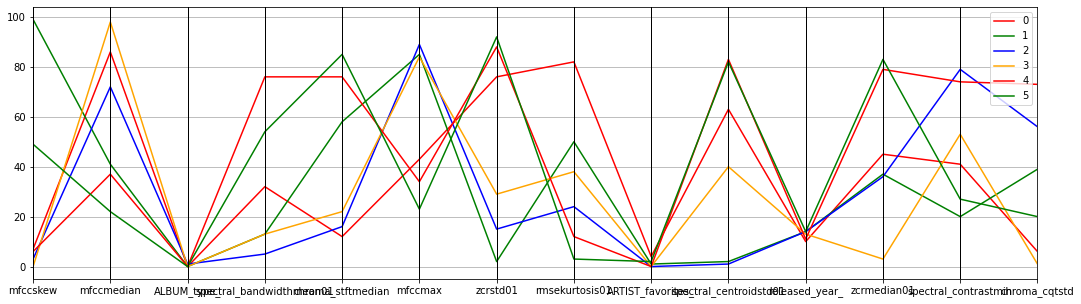

In [56]:
plt.figure(figsize=(18,5))
pd.plotting.parallel_coordinates(clusters_df, "cluster", color=["red", "green", "blue", "orange"]);

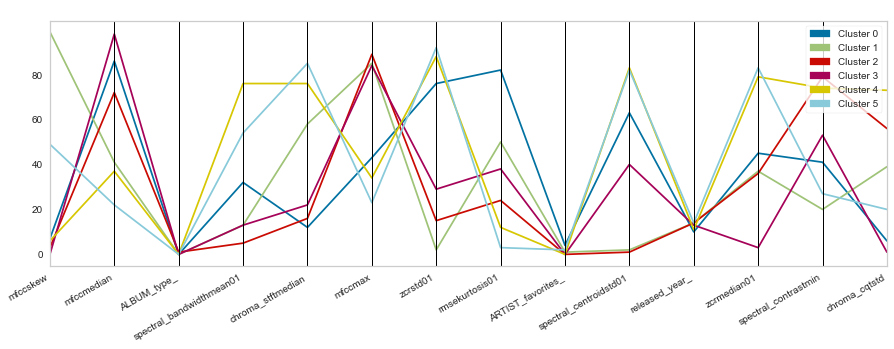

In [57]:
from yellowbrick.features.pcoords import parallel_coordinates
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    "mfccskew",
    "mfccmedian",
    "ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]
classes = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    size=(1080, 360), alpha=1,
    title=" "
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(clusters_df[features], clusters_df["cluster"])
visualizer.ax.set_yticks(range(0,100, 20))
visualizer.fig.autofmt_xdate()

# Finalize the title and axes then display the visualization
visualizer.show()

## Analisi cluster

In [58]:
df['clusters'] = clusters

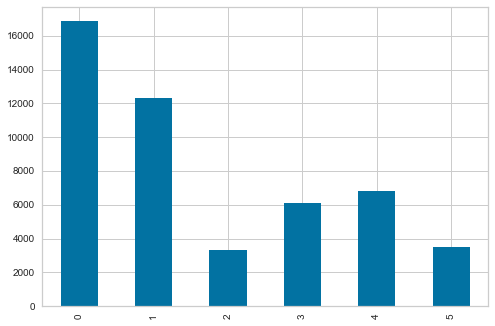

In [59]:
df.clusters.value_counts().sort_index().plot(kind='bar')

In [64]:
rock = df[df["TRACK_genre_top_num"]==1].clusters.value_counts().sort_index().values
other = df[df["TRACK_genre_top_num"]==0].clusters.value_counts().sort_index().values
total = df.clusters.value_counts().sort_index().values

In [65]:
rock = rock/total
other = other/total

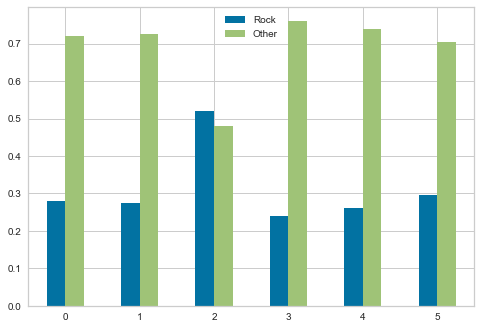

In [68]:
index = range(0, n_cluster)
df_bar = pd.DataFrame({'Rock': rock,
                   'Other': other}, index=index)

ax = df_bar.plot.bar(rot=0)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9276, cost: 119396.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10662, cost: 130186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7232, cost: 128163.0
Run 3, iteration: 2/100, moves: 2409, cost: 128163.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16247, cost: 118853.0
Run 1, iteration: 2/100, moves: 10902, cost: 117544.0
Run 1, iteration: 3/100, moves: 46, cost: 117544.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16830, cost: 113746.0
Run 2, iteration: 2/100, moves: 1996, cost: 113746.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1

AttributeError: 'KModes' object has no attribute 'k'

AttributeError: 'KModes' object has no attribute 'k'

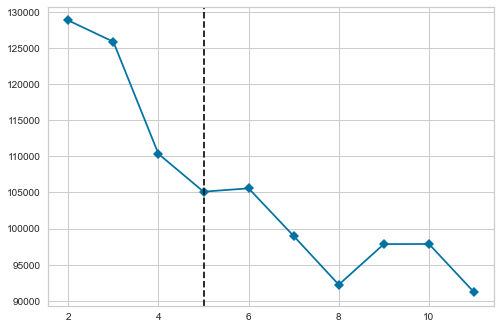

In [73]:
from yellowbrick.cluster import KElbowVisualizer

model = KModes(init='Huang', n_init=3, verbose=1)
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=True, title=" ")

visualizer.fit(Xt)

In [44]:
K = range(1, 26)
sse = []

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, n_jobs=-1)
    km.fit(Xt)
    sse.append((k, km.cost_))

Best run was number 1
Best run was number 2
Best run was number 4
Best run was number 3
Best run was number 3
Best run was number 3
Best run was number 5
Best run was number 5
Best run was number 3
Best run was number 3
Best run was number 4
Best run was number 5
Best run was number 3
Best run was number 3
Best run was number 2
Best run was number 3
Best run was number 4
Best run was number 2
Best run was number 2
Best run was number 2
Best run was number 2
Best run was number 5
Best run was number 4
Best run was number 4
Best run was number 1


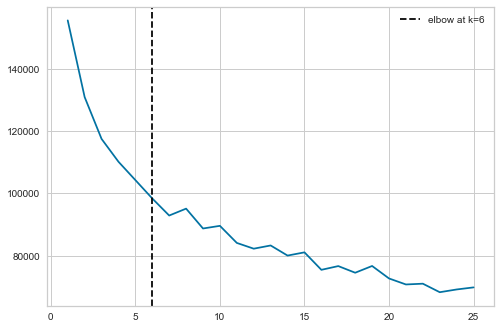

In [56]:
plt.plot(*zip(*sse))
plt.axvline(x=6, label='elbow at k=6',  ls='--', c='black')
plt.legend()
#plt.savefig("kmodes_sse.pdf", bbox_inches="tight")
plt.show()

In [50]:
from sklearn.metrics import silhouette_score

In [52]:
K = range(2, 26)
sil = []

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, n_jobs=-1)
    sil.append((k, silhouette_score(Xt, km.fit_predict(Xt))))

Best run was number 3
Best run was number 4
Best run was number 3
Best run was number 2
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 4
Best run was number 4
Best run was number 1
Best run was number 1
Best run was number 2
Best run was number 4
Best run was number 3
Best run was number 3
Best run was number 1
Best run was number 4
Best run was number 4
Best run was number 5
Best run was number 1
Best run was number 4
Best run was number 3
Best run was number 4
Best run was number 4


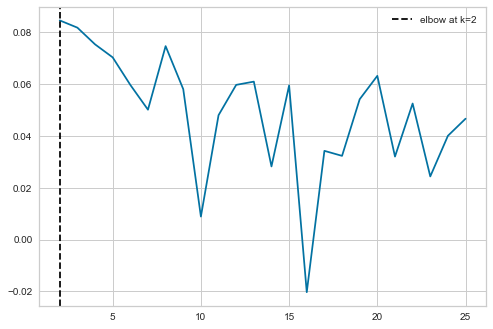

In [55]:
plt.plot(*zip(*sil))
plt.axvline(x=2, label='elbow at k=2',  ls='--', c='black')
plt.legend()
#plt.savefig("kmodes_silhouette.pdf", bbox_inches="tight")
plt.show()

## Rock

In [ ]:
from pyclustering.cluster import rock #LENTO

rc = rock.rock(X2[:100], eps=0.7, number_clusters=4, threshold=0.5)
rc.process()

In [ ]:
clusters = rc.get_clusters()